In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Path towards an "almost" fixed point

In [3]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.size'] = 6

np.set_printoptions(precision=3, suppress=True)

def first_N_harmonics(f, N=1):
    qx = np.fft.fftfreq(f.shape[-1], d=1/f.shape[-1])
    qy = np.fft.fftfreq(f.shape[-2], d=1/f.shape[-2])
    q = np.stack(np.meshgrid(qy, qx, indexing='ij'))
    q = np.linalg.norm(q, axis=0)
    
    x = np.fft.fftshift(f, axes=(-2, -1))
    q = np.fft.fftshift(q, axes=(-2, -1))
    bounds = np.argwhere(q <= N)
    i0 = np.min(bounds[:, 0])
    i1 = np.max(bounds[:, 0])
    j0 = np.min(bounds[:, 1])
    j1 = np.max(bounds[:, 1])
    return x[i0:i1+1, j0:j1+1][::-1, :] #Origin lower

def unshift(f, cutoff=1e-3):
    x = np.abs(f)**2
    x[x < cutoff * np.max(f)] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    x[x == -np.inf] = np.nan
    return x

def plot_tensor(E, Eq, label='E'):
    fig, ax = plt.subplots(2, 3, dpi=250, figsize=(3, 2))
    for a in ax.flatten(): a.set(xticks=[], yticks=[])
    ax[0, 0].set_ylabel('Fourier space')
    ax[1, 0].set_ylabel('Real space')

    plt.tight_layout()
    
    ax[0, 0].imshow(unshift(Eq[1, 1]), **kwargs)
    ax[1, 0].imshow(E[1, 1], cmap='inferno')
    ax[0, 0].set_title(r'$%s_{xx}$' % label)

    ax[0, 1].imshow(unshift(Eq[0, 0]), **kwargs)
    ax[1, 1].imshow(E[0, 0], cmap='inferno')
    ax[0, 1].set_title(r'$%s_{yy}$' % label)

    ax[0, 2].imshow(unshift(Eq[0, 1]), **kwargs)
    ax[1, 2].imshow(E[0, 1], cmap='inferno')
    ax[0, 2].set_title(r'$%s_{xy}$' % label)

## 1. Establish a cadherin pattern with low-order harmonics

Compute the fixed point while neglecting contributions from the convective derivative

$$ \dot{m}_{ij} = A[1 - k c] m_{ij} + B m_{ij} \text{Tr}(m) $$

$$ \text{Tr}(m_0) = -\frac{A}{B} [ 1 - k c] $$

Here, we establish a cadherin pattern with the spectrum 

\begin{equation}
    c(\mathbf{q}) = \begin{cases}
       c_0 ,& \mathbf{q} = 0 \\
       c_1 / 4 ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

The corresponding fixed point has the spectrum (note that $v(\mathbf{q}) \sim q^{-1} m(\mathbf{q})$)
\begin{equation}
    m_{yy}(\mathbf{q}) = \frac{A}{B} \begin{cases}
       -(1 - k\, c_0) ,& \mathbf{q} = 0 \\
       \frac{k}{4} c_1 ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

\begin{equation}
    \mathbf{v}(\mathbf{q}) = \frac{i \alpha}{\mu} \frac{A k c_1 }{4 B} \begin{cases}
       \frac{1}{2 q^2} \begin{pmatrix} -q_x \\ q_y \end{pmatrix}
           ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

Cadherin
[[0.1 0.  0.1]
 [0.  1.2 0. ]
 [0.1 0.  0.1]]

Myosin
[[-0.03 -0.   -0.03]
 [-0.    0.14 -0.  ]
 [-0.03 -0.   -0.03]]
m_yy(0, 0) = -A (1 - k c0) / B:	 True
m_yy(±1, ±1) = k A c1 / 4 B:	 True

Velocity
[[-0.022 -0.     0.022]
 [ 0.     0.    -0.   ]
 [-0.022 -0.     0.022]]
[[-0.022  0.    -0.022]
 [ 0.     0.     0.   ]
 [ 0.022  0.     0.022]]
Abs(Vx) = Abs(Vy):	 True
Vx(qx) = -Vx(-qx):	 True
Vy(qy) = -Vy(-qy):	 True
Abs(Vy(±1, ±1)) = (alpha A k c1) / (16 mu B):  True

RHS is zero:  True


Text(0.5, 1.0, '$A[1 - k c] m + B m^2$')

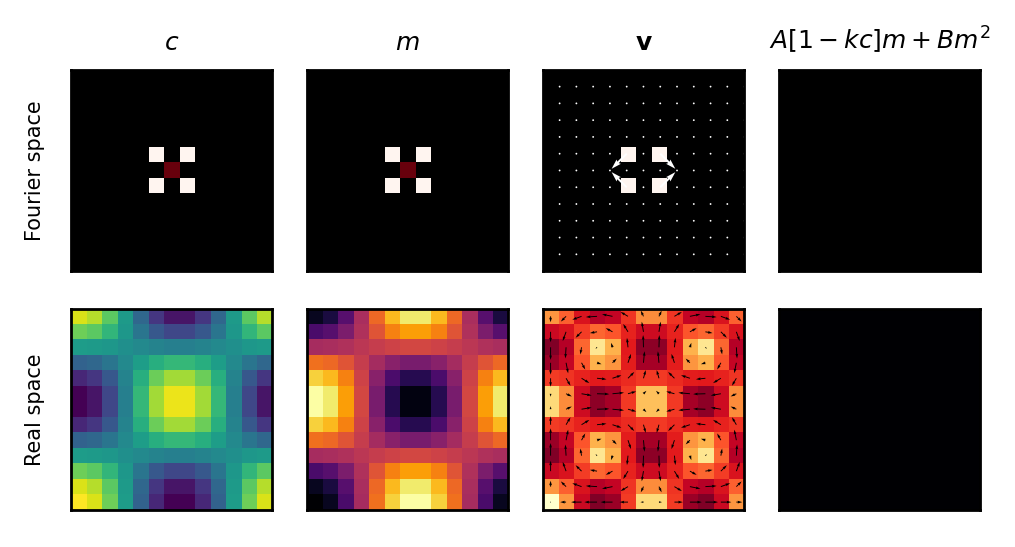

In [4]:
N = 13
half = N//2
qx = np.fft.fftfreq(N, 1/N)
qy = np.fft.fftfreq(N, 1/N)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
Y, X = np.meshgrid(y, x, indexing='ij')
qi = np.stack(np.meshgrid(qx, qy, indexing='ij'))
q = np.linalg.norm(qi, axis=0)

#Define parameters
alpha = 3
mu = 1
am = alpha / mu
A, B, k = 1, -1, 0.6
A, B = 1/3., -2/3.

cmap = plt.cm.Reds
cmap.set_bad('black')
kwargs = dict(cmap=cmap, extent=[qx.min(), qx.max(), qy.min(), qy.max()])
plt.cm.Reds.set_bad('black')
fig, ax = plt.subplots(2, 4, dpi=250, figsize=(4, 2))
for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

#Define cadherin field
cq = np.zeros([N, N])
c0, c1 = 1.2, 0.4
cq[ 0,  0] = c0
cq[ 1,  1] = c1 / 4
cq[ 1, -1] = c1 / 4
cq[-1,  1] = c1 / 4
cq[-1, -1] = c1 / 4
c = np.fft.ifft2(cq).real * N**2

print('Cadherin')
print(first_N_harmonics(cq, N=1).real)

ax[0, 0].imshow(unshift(cq), **kwargs)
ax[1, 0].imshow(c, cmap='viridis')
ax[0, 0].set_title(r'$c$')

#Myosin fixed point
mq = A / B * k * cq
mq[0, 0] -= A / B
m = np.fft.ifft2(mq).real * N**2

print('\nMyosin')
print(first_N_harmonics(mq, N=1).real)
print('m_yy(0, 0) = -A (1 - k c0) / B:\t', np.allclose(mq[0, 0], -A/B * (1 - k * c0))) 
print('m_yy(±1, ±1) = k A c1 / 4 B:\t', np.allclose(mq[1, 1], k * A * c1 / (4 * B)))

ax[0, 1].imshow(unshift(mq), **kwargs)
ax[1, 1].imshow(m, cmap='inferno')
ax[0, 1].set_title(r'$m$')

#Compute corresponding flow
vq     = -qi * qi[0]**2 / q**4
vq[0] += qi[0] / q**2
vq    = 1j * am * mq * vq.astype(np.complex128)
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real * N**2

print('\nVelocity')
print(first_N_harmonics(vq[1], N=1).imag)
print(first_N_harmonics(vq[0], N=1).imag)
print('Abs(Vx) = Abs(Vy):\t', np.allclose(np.abs(vq[0]), np.abs(vq[1])))
print('Vx(qx) = -Vx(-qx):\t', np.allclose(vq[1, :, 1:], -vq[1, :, 1:][:, ::-1]))
print('Vy(qy) = -Vy(-qy):\t', np.allclose(vq[0, 1:], -vq[0, 1:][::-1]))
print('Abs(Vy(±1, ±1)) = (alpha A k c1) / (16 mu B): ', np.allclose(vq[0, 1, 1].imag, am * A * k * c1 / (16 * B))) 

ax[0, 2].imshow(unshift(vq[0]), **kwargs)
ax[0, 2].quiver(qi[1], qi[0], vq[1].imag, vq[0].imag, 
                color='white', scale=3e-1, width=0.01)
ax[1, 2].quiver(vi[1], vi[0])
ax[1, 2].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
ax[0, 2].set_title(r'$\mathbf{v}$')

# Show RHS is zero
rhs = A * (1 - k * c) * m + B * m**2
rhsq = np.fft.fft2(rhs)

print('\nRHS is zero: ', np.allclose(rhsq, 0))
ax[0, 3].imshow(unshift(rhsq), **kwargs)
ax[1, 3].imshow(rhs, cmap='inferno', vmin=0, vmax=np.max(m))
ax[0, 3].set_title(r'$A[1 - k c] m + B m^2$')

### What is the linear stability of this fixed point?

It is convenient to write the myosin matrix as $m_{ij} = m D_{ij} (\theta)$, where 
\begin{equation}
    D(\theta) = \frac{1}{2} \begin{pmatrix}
        1 + \cos 2\theta & \sin 2\theta \\
        \sin 2\theta & 1 - \cos 2\theta
    \end{pmatrix}
\end{equation}
We also adopt the shorthand $\nabla_{\theta} D(\theta) = P (\theta)$. This allows us to separate the dynamical equation into terms which separately affect myosin orientation and concentration.
\begin{equation}
    D(\theta)\, \dot{m} + m P(\theta)\, \dot{\theta} = D(\theta) \left[ A (1 - k c) m + B m^2 \right]
\end{equation}
To perform a linear stability analysis, note the following identities
\begin{align}
    D(\theta + \delta \theta) &= D(\theta) + P(\theta) \,\delta \theta \\
    P(\theta + \delta \theta) &= P(\theta) + 2 \left[ I_2 - 2 D(\theta)\right] \, \delta \theta
\end{align}
Considering perturbations $m \rightarrow m + \delta m,\ \theta \rightarrow \theta + \delta \theta$ around a fixed point with $\dot{m} = 0, \ \dot{\theta} = 0,\ m = -A (1 - k c) / B$. Then the dynamical equation at $O(\delta)$ becomes
\begin{equation}
    D(\theta) \, \delta \dot{m} + P(\theta) \, \delta \dot{\theta} = D(\theta) \left[ A (1 - k c) + 2 B m \right] \delta m
\end{equation}

Thus, we have for our linear stability analysis after plugging in the proper value for $m$ on the RHS
\begin{align}
    \delta \dot{m} &= -A (1 - k c) \delta m \\
    \delta \dot{\theta} &= 0
\end{align}
We can obtain an exact expression by Fourier-transforming and explicitly plugging in the proper values of $c(\mathbf{q})$. Note that $c(\mathbf{q})$ is nonzero only for $\mathbf{q} = 0, (\pm 1, \pm 1)$ which means only a few terms will be present for each mode. The exact expression is:
\begin{equation}
    \delta \dot{m}(\mathbf{q}) = -A \sum_{\mathbf{q}'} \left[ \delta (\mathbf{q} - \mathbf{q}') - k c(\mathbf{q} - \mathbf{q}') \right] \delta m(\mathbf{q}')
\end{equation}
\begin{equation}
    \delta \dot{m}(\mathbf{q}) = -A \left\{ (1 - k c_0) \delta m (\mathbf{q}) - \frac{k c_1}{4} 
    \left[ \delta m (q_x + 1,q_y + 1) + \delta m (q_x + 1,q_y -1) + 
           \delta m (q_x - 1,q_y + 1) + \delta m (q_x - 1,q_y -1) \right] \right\} 
\end{equation}
In a typical regime where $A > 0$, we immediately see that a localized perturbation $\delta m(\mathbf{q}) = \delta m(\mathbf{k}) \ \delta (\mathbf{q} - \mathbf{k})$ is always stable. A less localized perturbation might look like
\begin{equation}
    \delta m(\mathbf{q}) = \sum_{dx = 0}^1 \sum_{dy = 0}^1 \delta m[\mathbf{k} + (dx, dy)]\, \delta [\mathbf{q} - \mathbf{k} - (dx, dy)]
\end{equation}
We can explicitly determine the linear stability of such a perturbation by writing the above equation in matrix form, with $P = -A(1 - k c_0)$ and $Q = A k c_1 / 4$
\begin{equation}
    \dot{\delta m}
    \begin{pmatrix}
        k_x,   k_y \\
        k_x+1, k_y \\
        k_x,   k_y+1 \\
        k_x+1, k_y+1
    \end{pmatrix} = 
    \begin{pmatrix}
     P & 0 & 0 & Q \\
     0 & P & Q & 0 \\
     0 & Q & P & 0 \\
     Q & 0 & 0 & P
    \end{pmatrix}
    \delta m \begin{pmatrix}
        k_x,   k_y \\
        k_x+1, k_y \\
        k_x+1, k_y+1 \\
        k_x,   k_y+1
    \end{pmatrix}
\end{equation}
The eigenvalues of this matrix are $P \pm Q$ each with degeneracy $2$. Note that $P < 0,\ Q > 0$ so the $P - Q < 0$ always. $P+Q > 0$ if 
\begin{equation}
    c_0 + \frac{c_1}{4} < \frac{1}{k}
\end{equation}
In our regime, we have $c_0 = 6/5,\, c_1 = 2/5,$ and $k = 3/5$, so these eigenvalues will also be negative and the fixed point is stable. Using Mathematica, we can consider larger systems. Below is a plot of the largest eigenvalue (for our choice of parameters) as system size is increased, showing that the system remains stable even for delocalized perturbations in Fourier space. This is ultimately a property of the cadherin distribution.

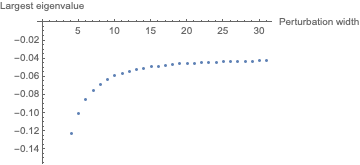

In [7]:
mij  = np.array([[1,  0], [0, 0]])[..., None, None] * m
mijq = np.array([[1,  0], [0, 0]])[..., None, None] * mq

env = 1 - (q / np.max(q))
print(first_N_harmonics(env, N=2))
dmij = (np.random.uniform(size=mij.shape) - 0.5) * 0.2 * mq[0, 0] * env
dmijq = np.fft.rfft2(dmij)
dmijq[:, :, :, 3:] = 0.
dmijq[:, :,  3:-2, :] = 0
dmij = np.fft.irfft2(dmijq, s=m.shape)
dmijq = np.fft.fft2(dmij)

dtrm =  dmij[0,0]  + dmij[1,1]
dtrmq = dmijq[0,0] + dmijq[1,1]

print('Applying a perturbation with trace') 
print(first_N_harmonics(dtrmq, N=3).real)

dtdm = A * (1 - k * c) * dmij + B * (mij * dtrm + m * dmij)
dtdmq = np.fft.fft2(dtdm)
print('\nTime derivative of perturbation')
print(first_N_harmonics(dtdmq[0, 0], N=4).real)

print('xx,xy,yx components are zero: ', 
      np.allclose(dtdmq[1, 0], 0), 
      np.allclose(dtdmq[0, 1], 0), 
      np.allclose(dtdmq[1, 1], 0))
print('yy components equal -A(1 - k c0) dm(q) + A k c1 / 4 \sum dm(q +\- 1):')
p1 = -A * (1 - k * c0)
p2 = A * k * c1 / 4
print('dt(dm(0,0))',
      np.allclose(dtdmq[0,0,0,0], p1 * dtrmq[0,0] + p2 * (dtrmq[1,1] + dtrmq[1,-1] + dtrmq[-1,1] + dtrmq[-1,-1])))
print('dt(dm(1,1))', 
      np.allclose(dtdmq[0,0,1,1], p1 * dtrmq[1,1] + p2 * (dtrmq[0,0] + dtrmq[0,2] + dtrmq[2,0] + dtrmq[2,2])))
print('dt(dm(2,0))',
      np.allclose(dtdmq[0,0,0,2], p1 * dtrmq[0,2] + p2 * (dtrmq[1,3] + dtrmq[-1,3] + dtrmq[-1,1] + dtrmq[1,1])))
print('dt(dm(2,2))',
      np.allclose(dtdmq[0,0,2,2], p1 * dtrmq[2,2] + p2 * (dtrmq[3,3] + dtrmq[1,1] + dtrmq[1,3] + dtrmq[3,1])))

[[0.667 0.736 0.764 0.736 0.667]
 [0.736 0.833 0.882 0.833 0.736]
 [0.764 0.882 1.    0.882 0.764]
 [0.736 0.833 0.882 0.833 0.736]
 [0.667 0.736 0.764 0.736 0.667]]
Applying a perturbation with trace
[[-0.     0.    -0.     0.    -0.     0.    -0.   ]
 [-0.     0.026  0.034  0.001  0.038  0.04  -0.   ]
 [-0.    -0.008  0.034 -0.059 -0.047  0.106 -0.   ]
 [-0.     0.062 -0.001  0.028 -0.001  0.062 -0.   ]
 [-0.     0.106 -0.047 -0.059  0.034 -0.008 -0.   ]
 [-0.     0.04   0.038  0.001  0.034  0.026 -0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.   ]]

Time derivative of perturbation
[[-0.     0.    -0.     0.     0.     0.     0.    -0.     0.   ]
 [ 0.     0.001  0.001  0.001  0.001  0.001  0.001  0.001 -0.   ]
 [ 0.    -0.    -0.002 -0.004 -0.    -0.003 -0.005  0.002 -0.   ]
 [ 0.     0.002  0.001 -0.001  0.007  0.007 -0.009  0.002  0.   ]
 [ 0.     0.002 -0.006 -0.    -0.003 -0.    -0.006  0.002  0.   ]
 [ 0.     0.002 -0.009  0.007  0.007 -0.001  0.001  0.002  0.   ]
 [-0.

### 1a. Can we find a fixed point for the orientation too?


In the above, the orientation angle is un-determined, and without including co-rotation or convection, it remains undetermined. If we include co-rotation, which does not affect the myosin intensity at each point, is there a unique fixed point for this equation?

The dynamics for the orientation angle $\theta$ reduce to
\begin{equation}
    \partial_t \theta + \frac{1}{2} \nabla^2 \psi = 0
\end{equation}

The stream function $\psi$, defined as $v_i = \epsilon_{ij} \nabla_j \psi$, must then be a harmonic function. It is generically given by a bi-harmonic equation

\begin{equation}
    \nabla^4 \psi = \frac{\alpha}{\mu} \left[
        \frac{1}{2} (\nabla_x^2 - \nabla_y^2) m \sin 2\theta - \nabla^2_{xy} m \cos 2\theta
    \right]
\end{equation}

For the constraint $\nabla^2 \psi = 0$ to be satisfied, we must also have that $\nabla^4 \psi = 0$, and so the right-hand side of the above must cancel. The intensity $m$ is already fixed, however, with $m = m_0 = -\frac{A}{B} (1 - k c)$. To find the $\theta$ that solves the above equation, we would like to use an iterative Newton's method, repeatedly selecting $\theta(\mathbf{x})$ such that
\begin{equation}
    \theta_{n+1} (\mathbf{x}) = \theta_{n}(\mathbf{x}) - J_F(\theta_{n})^{-1} F(\theta_{n})
\end{equation}

Computing this gradient in practice is expensive - we used an approximate iterative method (LBFGS) over in the FixedPointIteration.ipynb notebook.

Text(0.5, 1.0, '$m_{yy}$')

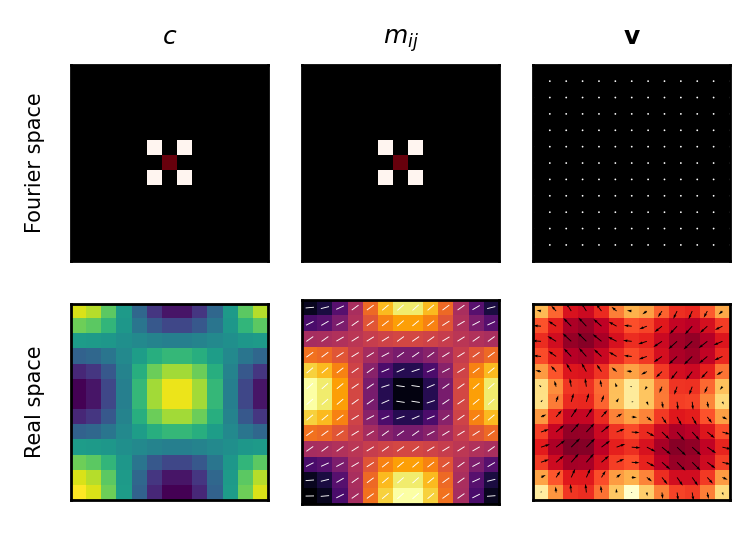

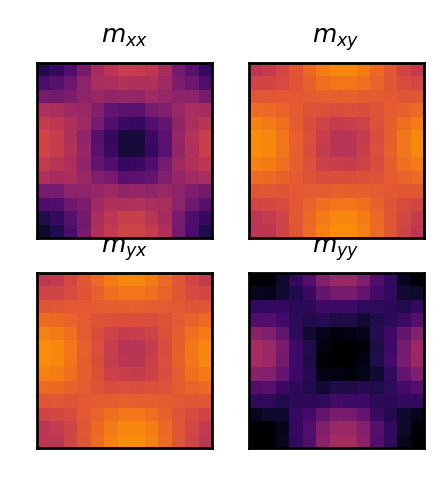

In [4]:
def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

fig, ax = plt.subplots(2, 3, dpi=250, figsize=(3, 2))
for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

ax[0, 0].imshow(unshift(cq), **kwargs)
ax[1, 0].imshow(c, cmap='viridis')
ax[0, 0].set_title(r'$c$')

#Get myosin angle
theta = np.load('FPtheta_LBFGS.npy')
mij = np.array([
    [np.sin(theta)**2, np.sin(theta) * np.cos(theta)],
    [np.sin(theta)*np.cos(theta), np.cos(theta)**2]]) * m
mijq = np.fft.fft2(mij) / N**2

trm, n = get_director_magnitude(mij)
trmq, nq = get_director_magnitude(mijq)

ax[0, 1].imshow(unshift(trmq), **kwargs)

twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
ax[1, 1].pcolormesh(X, Y, trm, cmap='inferno')
ax[1, 1].quiver(X, Y, n[..., 1].T, n[..., 0].T, **twargs)
ax[0, 1].set_title(r'$m_{ij}$')

#Compute corresponding flow
delta_ij = np.eye(2)
fj = np.einsum('kyx,jkyx->jyx', qi, mijq) / q**2
vq = np.einsum('ij,jyx->iyx', delta_ij, fj) - np.einsum('iyx,jyx,jyx->iyx', qi, qi, fj) / q**2
vq = -1j * am * vq
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real * N**2

ax[0, 2].imshow(unshift(vq[0]), **kwargs)
ax[0, 2].quiver(qi[1], qi[0], vq[1].imag, vq[0].imag, 
                color='white', scale=3e-1, width=0.01)
ax[1, 2].quiver(vi[1], vi[0])
ax[1, 2].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
ax[0, 2].set_title(r'$\mathbf{v}$')

fig, ax = plt.subplots(2, 2, dpi=250, figsize=(2, 2))
for a in ax.flatten(): a.set(xticks=[], yticks=[])
vmin = np.min(trm)
vmax = np.max(trm)
ax[0, 0].imshow(mij[1, 1], cmap='inferno', vmin=0, vmax=vmax)
ax[0, 1].imshow(mij[0, 1], cmap='inferno', vmin=-vmax, vmax=vmax)
ax[1, 0].imshow(mij[1, 0], cmap='inferno', vmin=-vmax, vmax=vmax)
ax[1, 1].imshow(mij[0, 0], cmap='inferno', vmin=0, vmax=vmax)

ax[0, 0].set_title('$m_{xx}$')
ax[0, 1].set_title('$m_{xy}$')
ax[1, 0].set_title('$m_{yx}$')
ax[1, 1].set_title('$m_{yy}$')

Text(0.5, 1.0, '$\\dot{m}_{yy}$')

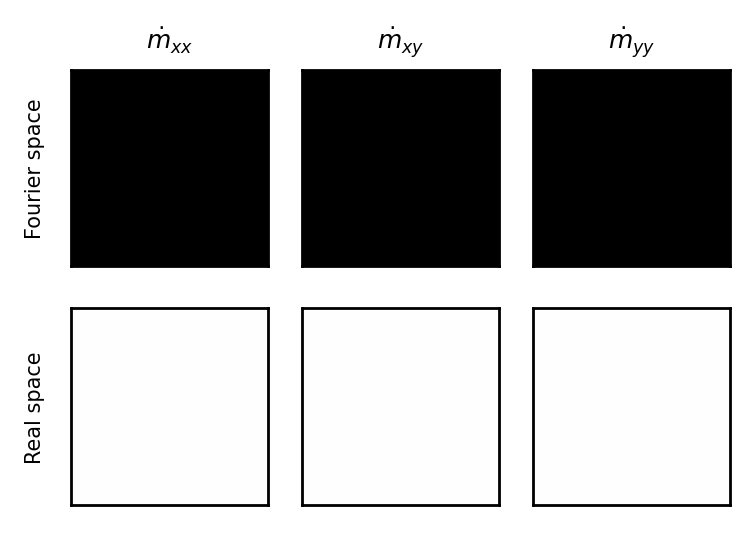

In [5]:
fig, ax = plt.subplots(2, 3, dpi=250, figsize=(3, 2))
for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

wq = 1j * (qi[1] * vq[0] - qi[0] * vq[1]) / 2.
w = np.fft.ifft2(wq).real * N**2

wij = np.array([[0, -1], [1, 0]])[..., None, None] * w
Om = np.einsum('ikyx,kjyx->ijyx', wij, mij) - np.einsum('ikyx,kjyx->ijyx', mij, wij)

dt_mij = A * (1 - k * c) * mij + B * mij * trm - Om
dt_mq = np.fft.fft2(dt_mij)

ax[0, 0].imshow(unshift(dt_mq[1, 1]), **kwargs)
ax[1, 0].imshow(dt_mij[1, 1], cmap='bwr', vmin=-np.std(mij), vmax=np.std(mij))
ax[0, 0].set_title(r'$\dot{m}_{xx}$')

ax[0, 1].imshow(unshift(dt_mq[0, 1]), **kwargs)
ax[1, 1].imshow(dt_mij[0, 1], cmap='bwr', vmin=-np.std(mij), vmax=np.std(mij))
ax[0, 1].set_title(r'$\dot{m}_{xy}$')

ax[0, 2].imshow(unshift(dt_mq[0, 0]), **kwargs)
ax[1, 2].imshow(dt_mij[0, 0], cmap='bwr', vmin=-np.std(mij), vmax=np.std(mij))
ax[0, 2].set_title(r'$\dot{m}_{yy}$')


Myosin
[[-0.03 -0.   -0.03]
 [-0.    0.14 -0.  ]
 [-0.03 -0.   -0.03]]


Text(0.5, 1.0, '$\\nabla^2_{xy} m$')

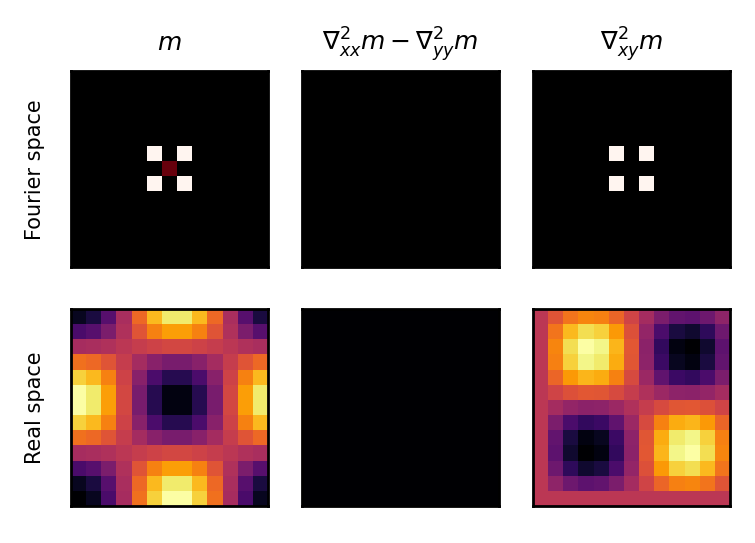

In [8]:
kwargs = dict(cmap=cmap, extent=[qx.min(), qx.max(), qy.min(), qy.max()])
fig, ax = plt.subplots(2, 3, dpi=250, figsize=(3, 2))
for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

print('\nMyosin')
print(first_N_harmonics(mq, N=1).real)

ax[0, 0].imshow(unshift(mq), **kwargs)
ax[1, 0].imshow(m, cmap='inferno')
ax[0, 0].set_title(r'$m$')

mq_xx = -qi[1]**2 * mq
mq_yy = -qi[0]**2 * mq
mq_xy = -qi[0]*qi[1] * mq

m_xx = np.fft.ifft2(mq_xx).real * N**2
m_yy = np.fft.ifft2(mq_yy).real * N**2
m_xy = np.fft.ifft2(mq_xy).real * N**2

ax[0, 1].imshow(unshift(mq_xx - mq_yy), **kwargs)
ax[1, 1].imshow(m_xx - m_yy, cmap='inferno')
ax[0, 1].set_title(r'$\nabla^2_{xx} m - \nabla^2_{yy} m$')

ax[0, 2].imshow(unshift(mq_xy), **kwargs)
ax[1, 2].imshow(m_xy, cmap='inferno')
ax[0, 2].set_title(r'$\nabla^2_{xy} m$')

## 2. Re-establish convective derivative and observe leading-order harmonic behavior

### Convective term

Using the above convention, the convective derivative can be decomposed as
\begin{equation}
    \mathbf{v} \cdot \nabla m_{ij} = D(\theta) \,\mathbf{v} \cdot \nabla m + m P(\theta) \,\mathbf{v} \cdot \nabla \theta
\end{equation}
We can simplify this by noting that at our "fixed" point we have $\theta$ constant so the second term cancels. For the firs term, we use the stream function $\psi$ defined as $v_i = \epsilon_{ij} \nabla_j \psi$, and define the cross product $\mathbf{a} \times \mathbf{b} = a_x b_y - a_y b_x$ to get
\begin{align}
    \mathbf{v} \cdot \nabla m (\mathbf{r}) &= -\nabla \psi \times \nabla m \\
    \mathbf{v} \cdot \nabla m (\mathbf{q}) &= -\sum_{\mathbf{q}'} \mathbf{q}' \times \mathbf{q} \, \tilde{\psi} (\mathbf{q}') \tilde{m }(\mathbf{q - q'})
\end{align}
Inserting the stream function into the Stokes equation leads to a biharmonic equation (see handwritten notes) for the stream function which can be solved for our fixed point
\begin{equation}
    \nabla^4 \psi = \frac{\alpha}{\mu} \left[ \frac{1}{2} \left(\nabla_x^2 - \nabla_y^2 \right) m \sin 2\theta - \nabla^2_{xy} m \cos 2\theta \right]
\end{equation}
\begin{equation}
    \tilde{\psi} = -\frac{\alpha}{\mu} \frac{q_x\,q_y}{q^4} \tilde{m}
\end{equation}
We can plug this stream function into the convective derivative to obtain
\begin{align}
        \mathbf{v} \cdot \nabla m (\mathbf{q}) &= \frac{\alpha}{\mu} \sum_{\mathbf{q'}} \mathbf{q}' \times \mathbf{q} \, \frac{q'_x\, q'_y}{q'^4} \tilde{m}(\mathbf{q}') \tilde{m }(\mathbf{q - q'}) 
\end{align}
The myosin fixed point means we have $\mathbf{q}' = 0, (\pm 1, \pm 1)$ and $\mathbf{q} - \mathbf{q}' = 0, (\pm 1, \pm 1)$. However, terms where $\mathbf{q}, \mathbf{q}' = 0$ or $\mathbf{q} || \mathbf{q'}$ will cancel. The only remaining possibility are $\mathbf{q} = (\pm 2, 0), (0, \pm 2)$. Plugging everthing in from our fixed points, we can find that
\begin{equation}
    \mathbf{v} \cdot \nabla m (\mathbf{q}) = \frac{\alpha}{\mu} \left( \frac{A k c_1 }{4 B}\right)^2
    \begin{cases}
        -1 ,&\mathbf{q} = (0, \pm 2) \\
         1 ,&\mathbf{q} = (\pm 2, 0) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation} 

Convective term
[[ 0.     0.    -0.003  0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.003  0.    -0.     0.     0.003]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.003  0.     0.   ]]
v.grad(m)(2, 0) = alpha / mu (k A c1 / 8 B)^2 q^2:  True


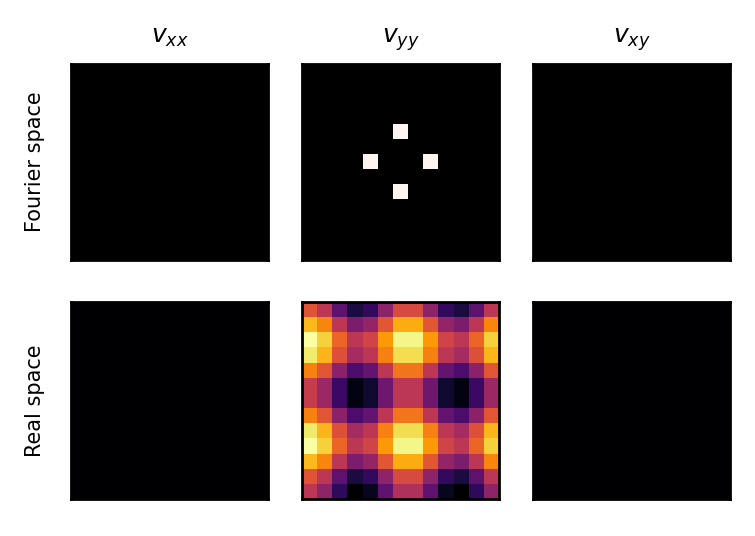

In [15]:
mij  = np.array([[1,  0], [0, 0]])[..., None, None] * m
mijq = np.array([[1,  0], [0, 0]])[..., None, None] * mq

print('Convective term')

gradmq = 1.0j * qi[:, None, None] * mijq[None]
gradm = np.fft.ifft2(gradmq).real

vgradm = np.einsum('kyx,kijyx->ijyx', vi, gradm)
vgradmq = np.fft.fft2(vgradm)

print(first_N_harmonics(vgradmq[0, 0], N=2).real)
print('v.grad(m)(2, 0) = alpha / mu (k A c1 / 8 B)^2 q^2: ', np.allclose(vgradmq[0, 0, 0, 2].real,
                                                                         am * (k * A * c1 / 8 / B)**2 * 4))

plot_tensor(vgradm, vgradmq, 'v')

### Co-rotational term

We can similarly simplify the co-rotation term $[\Omega, m]_{ij} = \Omega_{ik} m_{kj} - m_{ik} \Omega_{kj}$. First note that $\Omega_{ij} = - \epsilon_{ij}\nabla^2 \psi / 2$. We can couple this with the decomposition into $P, D$ matrices from earlier to write
\begin{equation}
    [\Omega, m]_{ij} = \frac{1}{2} m\, P(\theta) \, \nabla^2 \psi
\end{equation}
Thus, the convective derivative only affects the myosin concentration and the co-rotational term only affects the myosin orientation. 
We can use the Fourier-space representation of $\psi$ to immediately write $\tilde{\Omega}(\mathbf{q}) = -\frac{\alpha}{2 \mu} \frac{q_x\,q_y}{q^2} \tilde{m} (\mathbf{q})$ - this is more for a sanity check than anything else. 

We can explicitly compute the spectrum for $[\Omega, m]$ if we want but it suffices to note that the dynamical contribution to $\dot{\theta}$ is simpler. The full dynamical equation can be decomposed
\begin{equation}
    \dot{m}_{ij} + (\mathbf{v} \cdot \nabla) m_{ij} + [\Omega, m]_{ij} = A (1 - k c) m_{ij} + B m_{ij} \text{Tr}(m) \\
\end{equation}
\begin{equation}
    D(\theta) \left[ \dot{m} - \nabla \psi \times \nabla m \right] + m\, P(\theta) \left[ \dot{\theta} + \frac{1}{2} \nabla^2 \psi \right] = D(\theta) \left[ A (1 - k c) m + B m^2 \right] 
\end{equation}
Thus we here have that $\dot{\theta} = -\frac{1}{2} \nabla^2 \psi$. This is quite simply to write as we find that
\begin{equation}
    \dot{\theta} (\mathbf{q}) = -\frac{\alpha}{2 \mu} \frac{q_x\, q_y}{q^2} \tilde{m}(\mathbf{q}) = 
    -\frac{\alpha}{2\mu} \frac{A k c_1}{4 B} \begin{cases}
        \frac{q_x q_y}{q^2} ,&\mathbf{q} = (\pm 1, \pm 1) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

The co-rotation term $[\Omega, m]_{ij} = \Omega_{ik} m_{kj} - m_{ik} \Omega_{kj}$ is symmetric and has no diagonal component - co-rotation only re-orients the vector field rather than increasing density (trace). The spectrum of the vorticity is
\begin{equation}
    \Omega(\mathbf{q}) = -\frac{\alpha}{2\mu} \frac{A k c_1}{4 B}
    \begin{cases}
        \frac{q_x q_y}{q^2} ,&\mathbf{q} = (\pm 1, \pm 1) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

which leads to the following spectrum for $[\Omega, m]$
\begin{equation}
    [\Omega, m]_{xy} (\mathbf{q}) = \frac{\alpha}{2\mu} \left(\frac{A k c_1}{4 B} \right)^2 \frac{q_x q_y}{q^2} 
    \begin{cases}
        4 \frac{1 - k c_0}{k c_1}
         ,&\mathbf{q} = (\pm 1, \pm 1) \\
        -1 ,&\mathbf{q} = (\pm 2, \pm 2) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

Note that each of the above nonlinearities introduces contributions at higher wavenumbers that scale as $m(\mathbf{q})$. However, only the co-rotation term induces an effect at the leading-order harmonics, meaning that the orientational order of this fixed point is not stable.


Co-rotation term
[[ 0.001  0.     0.    -0.    -0.001]
 [ 0.    -0.003  0.     0.003 -0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [-0.     0.003  0.    -0.003  0.   ]
 [-0.001 -0.     0.     0.     0.001]]
Co-rotation is symmetric:	 True
Co-rotation has no diagonal:	 True
|[O, m](±1, ±1)| =  4 alpha q_x q_y / (2 mu q^2) (A k c1 / 4 B)^2 (1 - k c0) / (k c1):  True
|[O, m](±2, ±2)| =   -alpha q_x q_y / (2 mu q^2) (A k c1 / 4 B)^2: 	 True


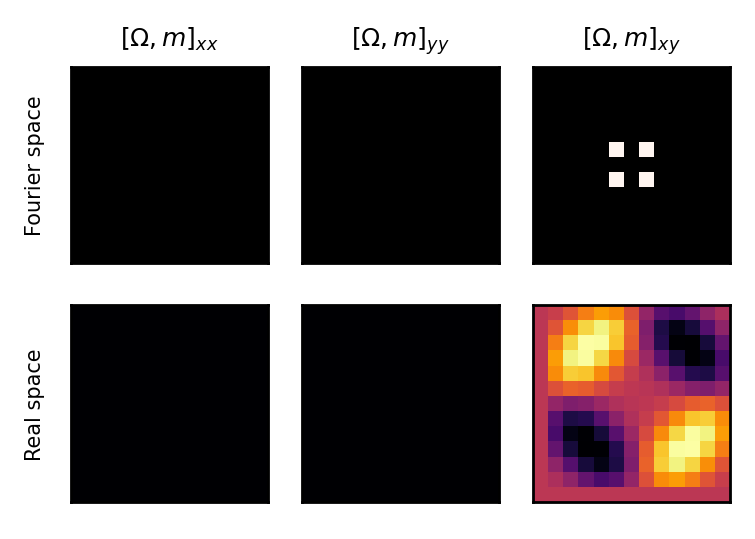

In [16]:
wq = 1j * (qi[1] * vq[0] - qi[0] * vq[1]) / 2.
w = np.fft.ifft2(wq).real * N**2

wij = np.array([[0, -1], [1, 0]])[..., None, None] * w
Om = np.einsum('ikyx,kjyx->ijyx', wij, mij) - np.einsum('ikyx,kjyx->ijyx', mij, wij)
Omq = np.fft.fft2(Om) / N**2

print('\nCo-rotation term')
print(first_N_harmonics(Omq[1, 0], N=2).real)

print('Co-rotation is symmetric:\t', np.allclose(Omq, Omq[::-1, ::-1]))
print('Co-rotation has no diagonal:\t', np.logical_and(np.allclose(Omq[0, 0], 0), np.allclose(Omq[1, 1], 0)))

print('|[O, m](±1, ±1)| =  4 alpha q_x q_y / (2 mu q^2) (A k c1 / 4 B)^2 (1 - k c0) / (k c1): ', 
      np.allclose(Omq[1, 0, 1, 1].real,  4 * am * 1 / (2 * 2) * (A * k * c1 / (4*B))**2 * (1 - k * c0) / (k * c1)))
print('|[O, m](±2, ±2)| =   -alpha q_x q_y / (2 mu q^2) (A k c1 / 4 B)^2: \t', 
      np.allclose(Omq[1, 0, 2, 2].real, -1 * am * 4 / (2 * 8) * (k * A * c1 / (4*B))**2))

plot_tensor(Om, Omq, '[\\Omega, m]')

## 3. Mitigate leading-order effects of convective derivative via mechanical feedback

The co-rotation term destroys orientational order by adding a finite rate of change to the orientation field $\dot{\theta} = -\frac{1}{2} \nabla^2 \psi$. We consider the effect of adding a mechanical feedback such as $\{ m, E \}_{ij} = m_{ik} E_{kj} + E_{ik} m_{kj}$. We can compute the strain rate tensor $E_{ij} = \frac{1}{2} (\partial_i v_j - \partial_j v_i) = \frac{1}{2} ( \epsilon_{jk} \psi_{ik} + \epsilon_{ik} \psi_{jk})$. More explicitly, we find
\begin{equation}
    E_{ij}(\mathbf{q}) = -\frac{1}{2} \tilde{\psi}(\mathbf{q})\begin{pmatrix}
        2 q_x q_y & q_y^2 - q_x^2 \\
        q_y^2 - q_x^2 & -2 q_x q_y 
    \end{pmatrix}
\end{equation}
Note that the off diagonal components are zero as $\psi(\mathbf{q}) \sim m(\mathbf{q})$ and $m(\mathbf{q}) \neq 0$ only when $q_x^2 = q_y^2$. Then we can simplify this as 
\begin{align}
    E_{ij}(\mathbf{q}) = E(\mathbf{q})\, \sigma_z
\end{align}
Where we wrote
\begin{align}
    E(\mathbf{q}) = -q_x\,q_y \psi(\mathbf{q}) \quad \quad
    \sigma_z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
\end{align}

Plugging in our prior result for $\psi$, we can write
\begin{align}
    E(\mathbf{q}) = \frac{\alpha}{\mu} \left(\frac{q_x q_y}{q^2}\right)^2 \tilde{m}(\mathbf{q})
\end{align}

## 3. Eliminate leading-order effects of convective derivative

The co-rotation term destroys orientational order by introducing a $\mathbf{q} = (\pm 1, \pm 1)$ off-diagonal component to the left-hand side, and the convective derivative introduces higher-wavenumber modes to the myosin profile. Over time, these new components will propagate down the spectrum and introduce more high-frequency components which destroy order. We consider the effect of a mechanical feedback term to suppress this behavior.

First, note that for the strain rate tensor $E_{ij} = (\partial_i v_j + \partial_j v_i) / 2$, $E_{xy} = 0$ and $E_{xx} + E_{yy} = 0$ by incompressibility. We have that 
\begin{equation}
    E_{yy} = -E_{xx} = -\frac{\alpha}{2\mu}\frac{A k c_1}{4 \mu B} \begin{cases}
         \frac{q_y^2}{q^2},& \mathbf{q} = (\pm 1, \pm 1) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

Strain rate tensor
[[0.    0.    0.    0.    0.   ]
 [0.    0.022 0.    0.022 0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.022 0.    0.022 0.   ]
 [0.    0.    0.    0.    0.   ]]
E_yy(±1, ±1)) = -(alpha A k c1) / (16 mu B):  True

Strain-recruitment term
[[-0.001 -0.    -0.003 -0.    -0.001]
 [-0.     0.006 -0.     0.006 -0.   ]
 [-0.003  0.    -0.005  0.    -0.003]
 [-0.     0.006 -0.     0.006 -0.   ]
 [-0.001 -0.    -0.003 -0.    -0.001]]

Cadherin-coupled strain-recruitment term
[[-0.001  0.    -0.002  0.    -0.001]
 [-0.     0.006  0.     0.006 -0.   ]
 [-0.002  0.    -0.004  0.    -0.002]
 [-0.     0.006  0.     0.006 -0.   ]
 [-0.001  0.    -0.002  0.    -0.001]]


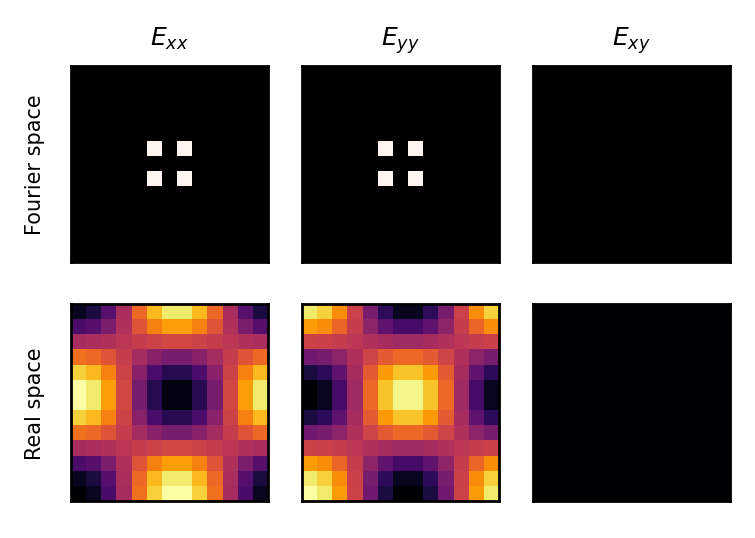

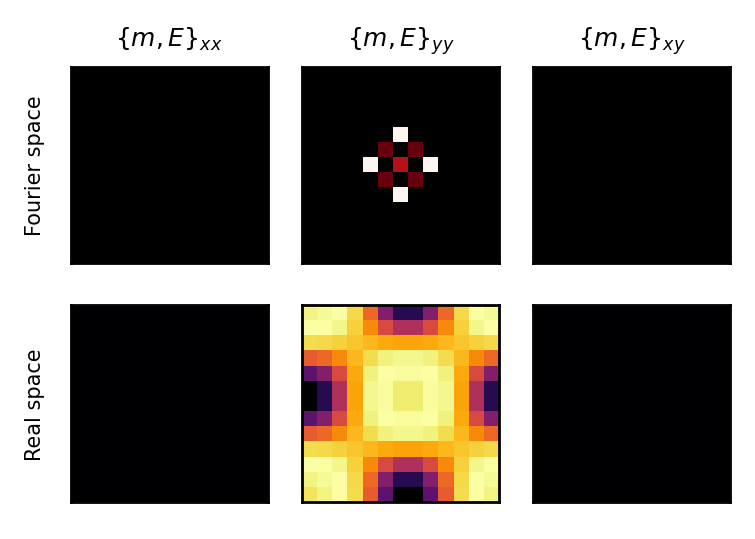

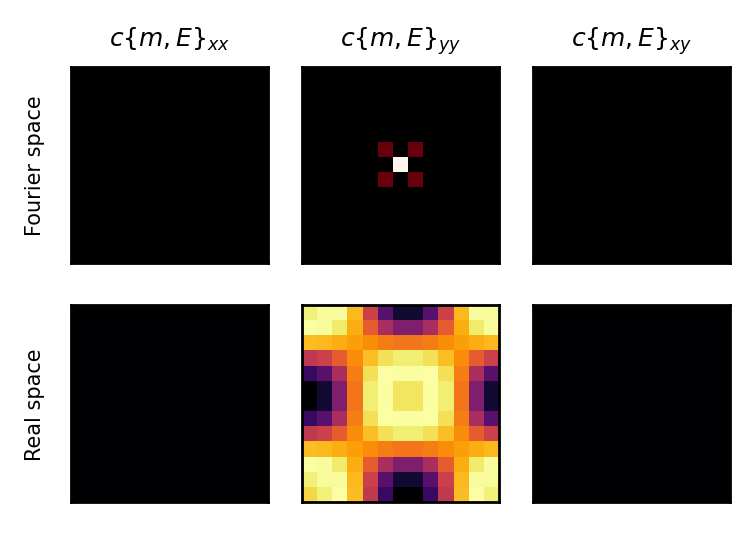

In [21]:
Eijq = np.einsum('iyx,jyx->ijyx', qi, vq)
Eijq = 1j / 2. * (Eijq + np.einsum('ijyx->jiyx', Eijq))
Eij = np.fft.ifft2(Eijq).real * N**2

print('Strain rate tensor')
print(first_N_harmonics(Eijq[0, 0], N=2).real)
print('E_yy(±1, ±1)) = -(alpha A k c1) / (16 mu B): ', np.allclose(Eijq[0, 0, 1, 1].real, -am * A * k * c1 / (16 * B))) 

plot_tensor(Eij, Eijq, 'E')

Em = np.einsum('ikyx,kjyx->ijyx', Eij, mij) + np.einsum('ikyx,kjyx->ijyx', mij, Eij)
Emq = np.fft.fft2(Em) / N**2

plot_tensor(Em, Emq, '\\{ m, E\\}')
print('\nStrain-recruitment term')
print(first_N_harmonics(Emq[0, 0], N=2).real)

cEm = c * Em
cEmq = np.fft.fft2(cEm) / N**2
plot_tensor(cEm, cEmq, 'c \\{ m, E\\}')

print('\nCadherin-coupled strain-recruitment term')
print(first_N_harmonics(cEmq[0, 0], N=2).real)

Convective derivative
[[ 0.     0.    -0.003  0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.003  0.    -0.     0.     0.003]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.003  0.     0.   ]]

Strain-recruitment term
[[-0.001  0.    -0.002  0.    -0.001]
 [-0.     0.002 -0.     0.002 -0.   ]
 [-0.002 -0.    -0.003 -0.    -0.002]
 [-0.     0.002 -0.     0.002 -0.   ]
 [-0.001  0.    -0.002  0.    -0.001]]

Strain-recruitment term
[[-0.001 -0.    -0.003 -0.    -0.001]
 [-0.     0.006 -0.     0.006 -0.   ]
 [-0.003  0.    -0.005  0.    -0.003]
 [-0.     0.006 -0.     0.006 -0.   ]
 [-0.001 -0.    -0.003 -0.    -0.001]]

Strain-recruitment term
[[-0.002 -0.    -0.004 -0.    -0.002]
 [-0.     0.01  -0.     0.01  -0.   ]
 [-0.004  0.    -0.008  0.    -0.004]
 [-0.     0.01  -0.     0.01  -0.   ]
 [-0.002 -0.    -0.004 -0.    -0.002]]


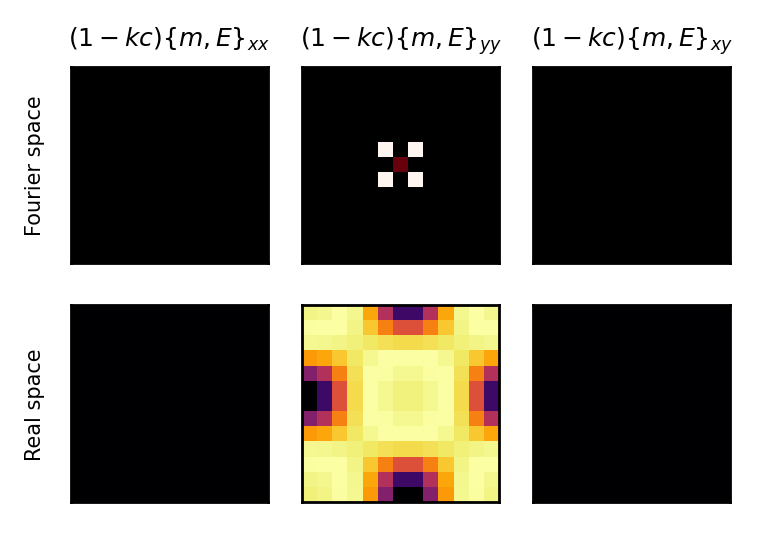

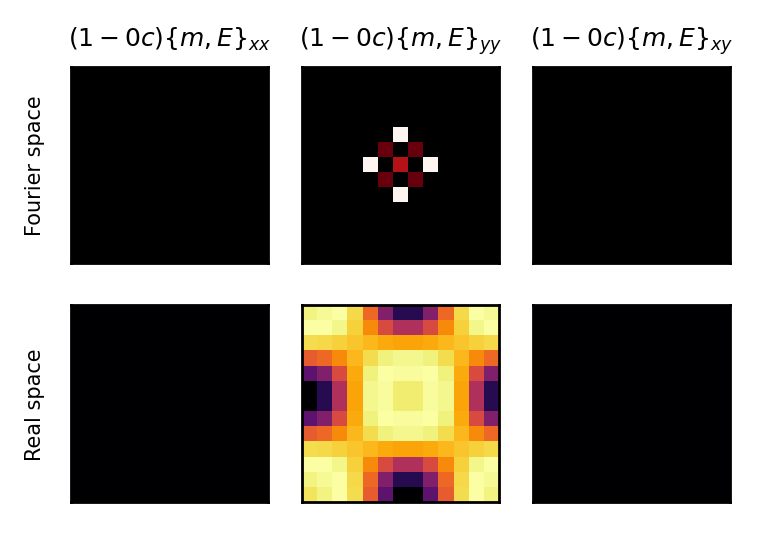

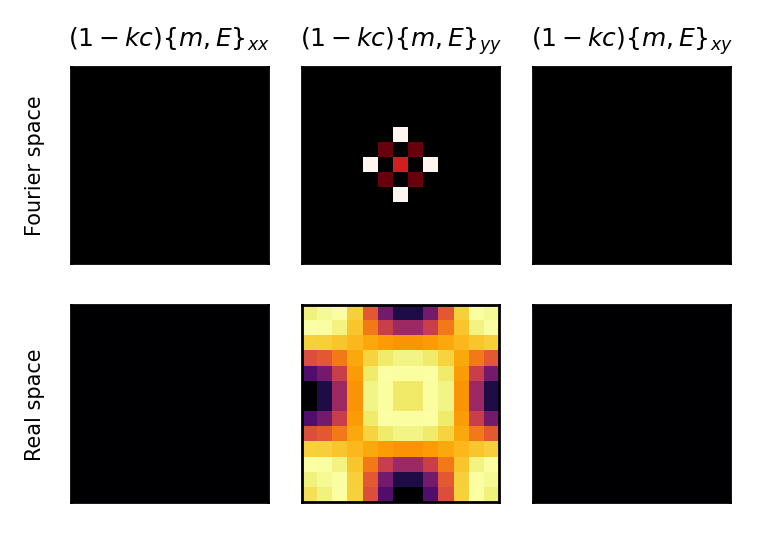

In [22]:
print('Convective derivative')
print(first_N_harmonics(vgradmq[0, 0], N=2).real)

cEm = (1 - k * c) * Em
cEmq = np.fft.fft2(cEm) / N**2
plot_tensor(cEm, cEmq, '(1 - k c) \\{ m, E\\}')

print('\nStrain-recruitment term')
print(first_N_harmonics(cEmq[0, 0], N=2).real)


cEm = Em
cEmq = np.fft.fft2(cEm) / N**2
plot_tensor(cEm, cEmq, '(1 - 0 c) \\{ m, E\\}')

print('\nStrain-recruitment term')
print(first_N_harmonics(cEmq[0, 0], N=2).real)


cEm = (1 + k * c) * Em
cEmq = np.fft.fft2(cEm) / N**2
plot_tensor(cEm, cEmq, '(1 - k c) \\{ m, E\\}')

print('\nStrain-recruitment term')
print(first_N_harmonics(cEmq[0, 0], N=2).real)